### Import all dependencies

In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [2]:

IMAGE_SIZE = [224, 224] 


epochs = 500
batch_size = 32


pneumonia_path = 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA'
nonpneumonia_path = 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/1Chest_NonPNEUMONIA'


pneumonia_files = glob(pneumonia_path + '/*')
nonpneumonia_files = glob(nonpneumonia_path + '/*')

In [3]:
# Visualize file variable contents
print("First 5 pneumonia Files: ",pneumonia_files[0:5])
print("Total Count: ",len(pneumonia_files))
print("First 5 Nonpneumonia Files: ",nonpneumonia_files[0:5])
print("Total Count: ",len(nonpneumonia_files))

First 5 pneumonia Files:  ['C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA\\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA\\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg.jpg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA\\03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA\\03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg.jpg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA\\1-s2.0-S0140673620303706-fx1_lrg.jpg']
Total Count:  435
First 5 Nonpneumonia Files:  ['C:/Users/admin/PNEUMONIA DETECTION/data/chest/1Chest_NonPNEUMONIA\\002c591d-df62-4e34-8eda-838c664430a9.jpg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/1Chest_NonPNEUMONIA\\003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg', 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/1Chest_NonPNEUMONIA\\00a85be6-6eb0-421d-8acf-ff2dc0007e8a.jpg', 'C:/Users/admin/PNEUMONIA DETECTION/data/che

### Fetch Images and Class Labels from Files (This might take a while)

In [4]:
# Fetch Images and Class Labels from Files
pneumonia_labels = []
nonpneumonia_labels = []

pneumonia_images=[]
nonpneumonia_images=[]

for i in range(len(pneumonia_files)):
  image = cv2.imread(pneumonia_files[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(224,224)) 
  pneumonia_images.append(image) 
  pneumonia_labels.append('0CT_PNEUMONIA') 
for i in range(len(nonpneumonia_files)):
  image = cv2.imread(nonpneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonpneumonia_images.append(image)
  nonpneumonia_labels.append('1CT_NonPNEUMONIA')
print("Number of PNEUMONIA images:", len( pneumonia_images))
print("Number of non-PNEUMONIA images:", len(nonpneumonia_images))

Number of PNEUMONIA images: 435
Number of non-PNEUMONIA images: 505


### Visualize First 40 Images from Data set

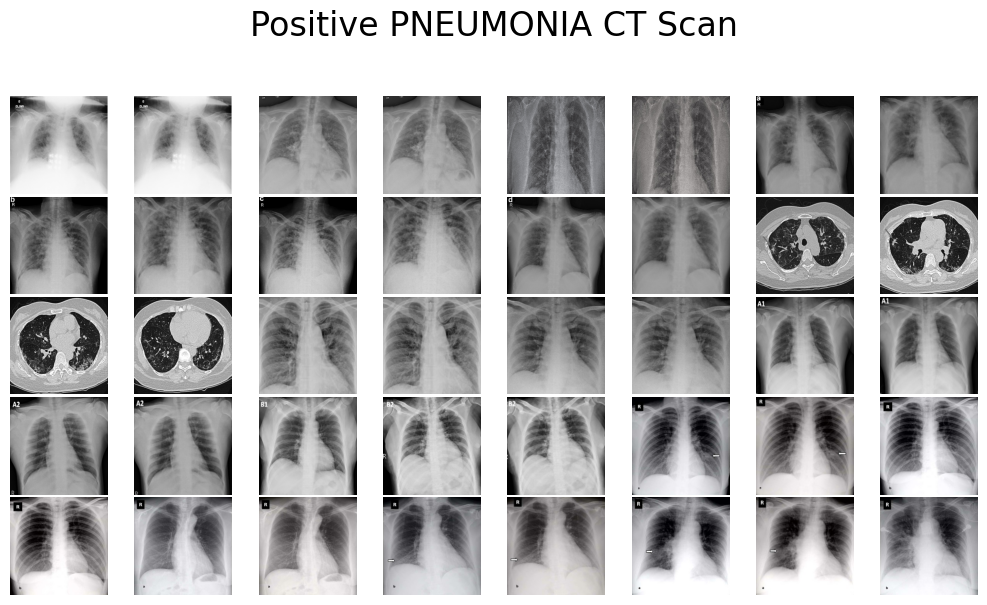

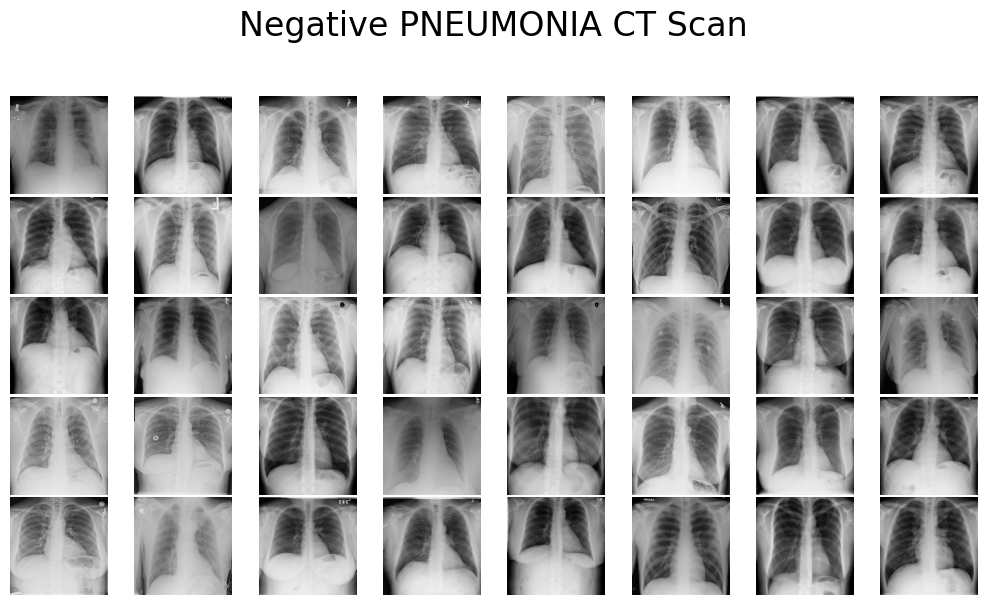

In [5]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(pneumonia_images, 'Positive PNEUMONIA CT Scan')
plot_images(nonpneumonia_images, 'Negative PNEUMONIA CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [6]:
# Convert to array and Normalize to interval of [0,1]
pneumonia_images = np.array(pneumonia_images) / 255
nonpneumonia_images = np.array(nonpneumonia_images) / 255

### **Train Test Split**

In [7]:
# split into training and testing
pneumonia_x_train, pneumonia_x_test, pneumonia_y_train, pneumonia_y_test = train_test_split(
    pneumonia_images, pneumonia_labels, test_size=0.2)
nonpneumonia_x_train, nonpneumonia_x_test, nonpneumonia_y_train, nonpneumonia_y_test = train_test_split(
    nonpneumonia_images, nonpneumonia_labels, test_size=0.2)


X_train = np.concatenate((nonpneumonia_x_train, pneumonia_x_train), axis=0)
X_test = np.concatenate((nonpneumonia_x_test, pneumonia_x_test), axis=0)
y_train = np.concatenate((nonpneumonia_y_train, pneumonia_y_train), axis=0)
y_test = np.concatenate((nonpneumonia_y_test, pneumonia_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

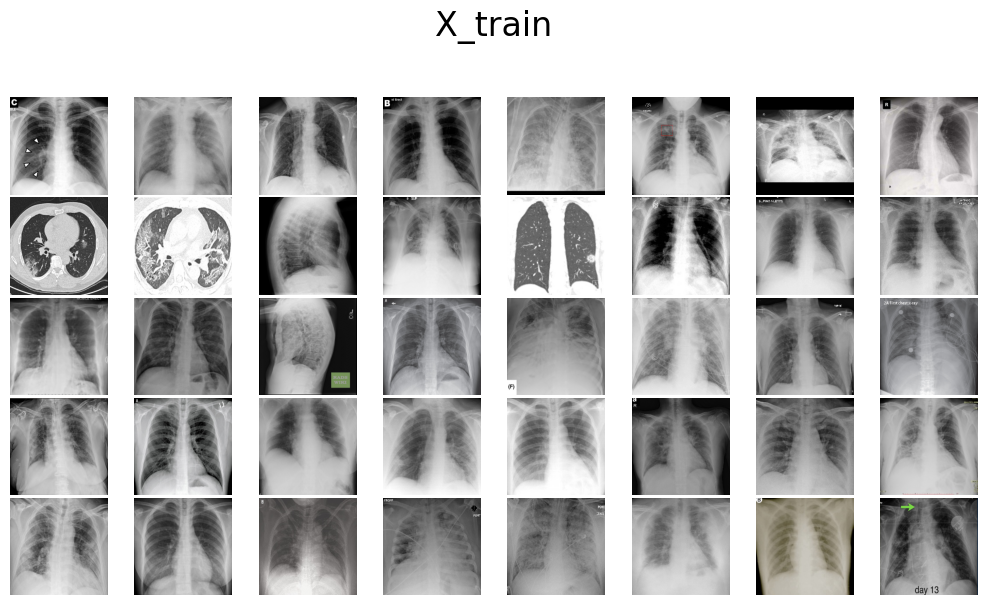

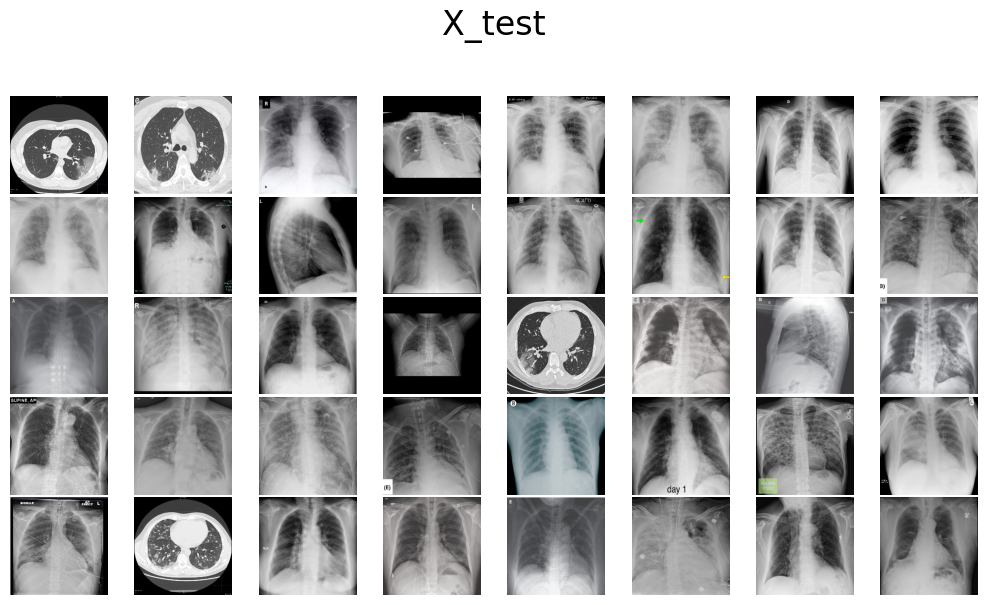

In [8]:
plot_images(pneumonia_x_train, 'X_train')
plot_images(pneumonia_x_test, 'X_test')


### **Building and Visualizing model**

In [0]:
# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [0]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [0]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
19/18 [==============================] - 7s 357ms/step - loss: 1.6927 - accuracy: 0.5268 - val_loss: 1.3926 - val_accuracy: 0.4667
Epoch 2/500
19/18 [==============================] - 6s 307ms/step - loss: 1.1724 - accuracy: 0.5101 - val_loss: 0.8680 - val_accuracy: 0.5600
Epoch 3/500
19/18 [==============================] - 6s 306ms/step - loss: 0.9543 - accuracy: 0.5671 - val_loss: 0.7477 - val_accuracy: 0.6067
Epoch 4/500
19/18 [==============================] - 6s 310ms/step - loss: 1.2135 - accuracy: 0.5386 - val_loss: 2.0806 - val_accuracy: 0.4667
Epoch 5/500
19/18 [==============================] - 6s 303ms/step - loss: 1.2032 - accuracy: 0.5604 - val_loss: 0.9991 - val_accuracy: 0.5667
Epoch 6/500
19/18 [==============================] - 6s 306ms/step - loss: 0.9826 - accuracy: 0.5940 - val_loss: 1.4792 - val_accuracy: 0.4733
Epoch 7/500
19/18 [==============================] - 6s 307ms/step - loss: 0.9948 - accuracy: 0.6208 - val_loss: 0.8589 - val_accuracy: 0.6600

In [0]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [0]:
# Load saved model
model = load_model('resnet_ct.h5')

### **Making Predicions**

In [0]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

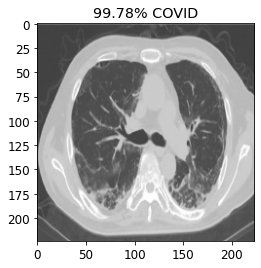

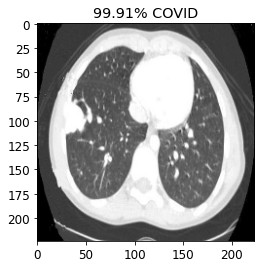

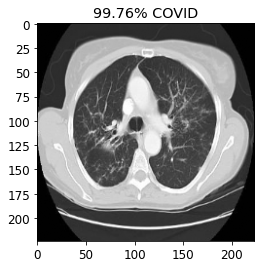

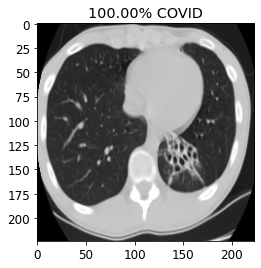

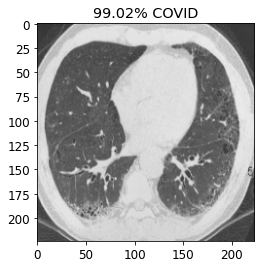

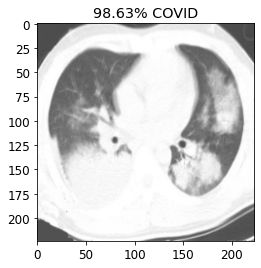

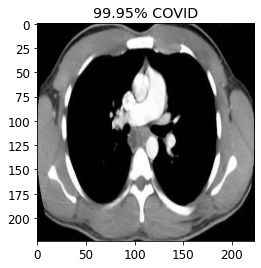

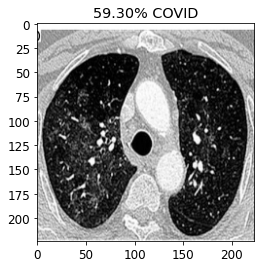

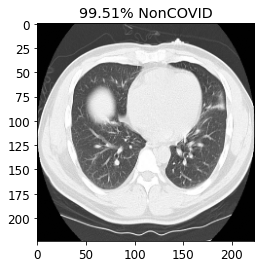

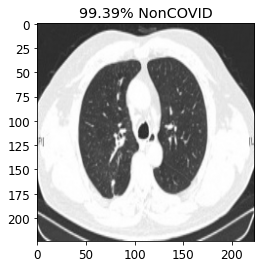

In [0]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonPNEUMONIA')
  plt.imshow(X_test[index])
  plt.show()

In [0]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

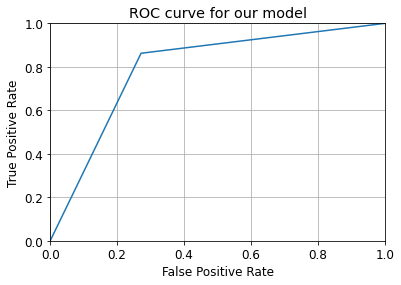

In [0]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

In [9]:
def plot_confusion_matrix(normalize):
  classes = ['PNEUMONIA','NonPNEUMONIA']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

Confusion Matrix without Normalization


NameError: name 'y_test_bin' is not defined

### **Classification Report**

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        70
           1       0.78      0.86      0.82        80

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.80      0.80      0.80       150



### **Accuracy and Loss Plots**

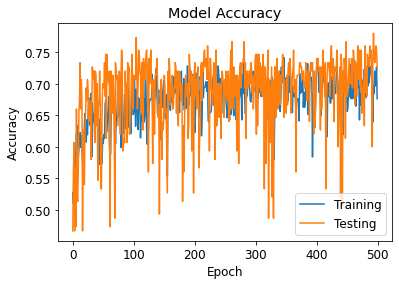

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()


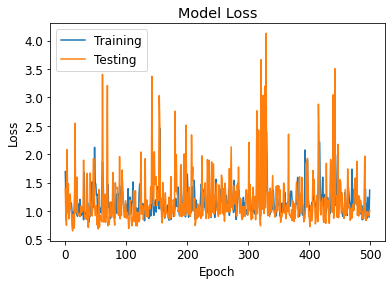

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()